### Libs

In [1]:
from tqdm import tqdm
import numpy as np
import os
import random
import glob
import re

import cv2
import geopandas as gpd
import pandas as pd

import albumentations as A

import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import segmentation_models_pytorch as smp
from torchvision.utils import make_grid, save_image
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

import model
import metrics
import config
import utis
import train_val_test

from matplotlib import pyplot as plt, cm
import plotly.express as px

from torch.utils.data import DataLoader, random_split
from dataset import HistoricalImagesDataset
import config

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

### Weights and Biases

In [2]:
!wandb login 

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


### Custom Split Dataset

In [2]:
# Paths
IMAGES_PATH = '../data/patches/images/1942'
MASK_PATH = '../data/patches/masks/1942'
BEST_MODEL = '../best_model'

FILTER_PATH = '../data/geopackages/patch_keys.gpkg'
TEST_DATASET_PATH = '../data/test_dataset'

image_paths = glob.glob(IMAGES_PATH +'/*.tif')
mask_paths = glob.glob(MASK_PATH +'/*.tif')

In [3]:
# Read file 
geo_df = gpd.read_file(FILTER_PATH) # contains the idxs with a selection of non-noisy and noisy data

# Define the filters 
filters = {'non_veg_idxs' : geo_df.query("status == 0")['index'],
       'veg_idxs' :  geo_df.query("status == 1")['index'], 
       'mixed': geo_df.query("status == 2")['index'], 
       'single_trees_idx' : geo_df.query("status == 3")['index'], 
       'hedgerows' : geo_df.query("status == 4")['index'], 
       'coarse_to_very_coarse': geo_df.query("status == 5")['index'][5:]}

# fix bug of the test_size
data_portion = 'fine_labels' # ['coarse_plus_fine_labels', 'fine_labels', 'coarse_labels']
n_patches = 20

X_train, y_train, X_val, y_val, X_test, y_test = utis.custom_split(filters, test_size=40, 
                                                                   image_paths=image_paths, 
                                                                   mask_paths=mask_paths,  
                                                                   data_portion=data_portion,
                                                                   DEST_PATH = TEST_DATASET_PATH,
                                                                   number_training_patchs=n_patches)

In [5]:
# idxs = [utis.get_file_index(file) for file in X_train]
# idd = '765' #1927 in val and 765
# idx = idxs.index(idd) #1927

# img = cv2.imread(X_train[idx], cv2.IMREAD_GRAYSCALE)
# msk = cv2.imread(y_train[idx], cv2.IMREAD_GRAYSCALE)

# fig, ax = plt.subplots(1,2, figsize=(10,10),  sharey=True)
# plt.gray()
# ax[0].imshow(img)
# ax[0].set_title(f'Original image - ID {idd}')
# ax[1].imshow(msk)
# ax[1].set_title(f'Coarse image - ID {idd}')

### Dataloader

In [4]:
# Define transformations
val_transform = A.Compose(
    [A.Normalize(mean=(0.512), std=(0.167)),
    ToTensorV2()])

train_transform = A.Compose([
      A.Rotate(limit=40,p=0.9, border_mode=cv2.BORDER_CONSTANT), # p stands for the probability with which the transformations are applied
      A.HorizontalFlip(p=0.9),
      A.VerticalFlip(p=0.9), 
      A.Transpose(p=0.9),
      A.CLAHE(p=1),
      A.Normalize(mean=(0.512), std=(0.167)),
      ToTensorV2()])

# Datasets
train_dataset = HistoricalImagesDataset(X_train, y_train, transform=train_transform, split_type=None)
val_dataset = HistoricalImagesDataset(X_val, y_val, transform=val_transform, split_type=None)
test_dataset = HistoricalImagesDataset(X_test, y_test, transform=val_transform, split_type='test')

data = next(iter(train_dataset))
print('shape train image', data[0].shape, 'shape train mask', data[1].shape) 

# Dataloader
print("Training set size: ", len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE, shuffle=True)
print("Validation set size: ", len(val_dataset))
val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE, shuffle=True)

print("Testing set size: ", len(test_dataset))
test_dataloader = DataLoader(dataset=test_dataset, batch_size = 1)

shape train image torch.Size([1, 256, 256]) shape train mask torch.Size([256, 256])
Training set size:  20
Validation set size:  6
Testing set size:  40


In [7]:
# def clahe_equalized(img: np.array) -> np.array: # this step should be before
#     ''' Apply CLAHE equalization'''
#     # np_img= np.asarray(img)
#     clahe = cv2.createCLAHE(clipLimit = 4.5, tileGridSize=(8, 8))
#     return clahe.apply(img)


# img = cv2.imread(X_test[15], cv2.IMREAD_GRAYSCALE)
# clahe_img = clahe_equalized(img)
# plt.gray()
# fig, ax = plt.subplots(1,2, figsize=(10,10),  sharey=True)
# ax[0].imshow(img)
# ax[0].set_title('Original image')
# ax[1].imshow(clahe_img)
# ax[1].set_title('CLAHE image')

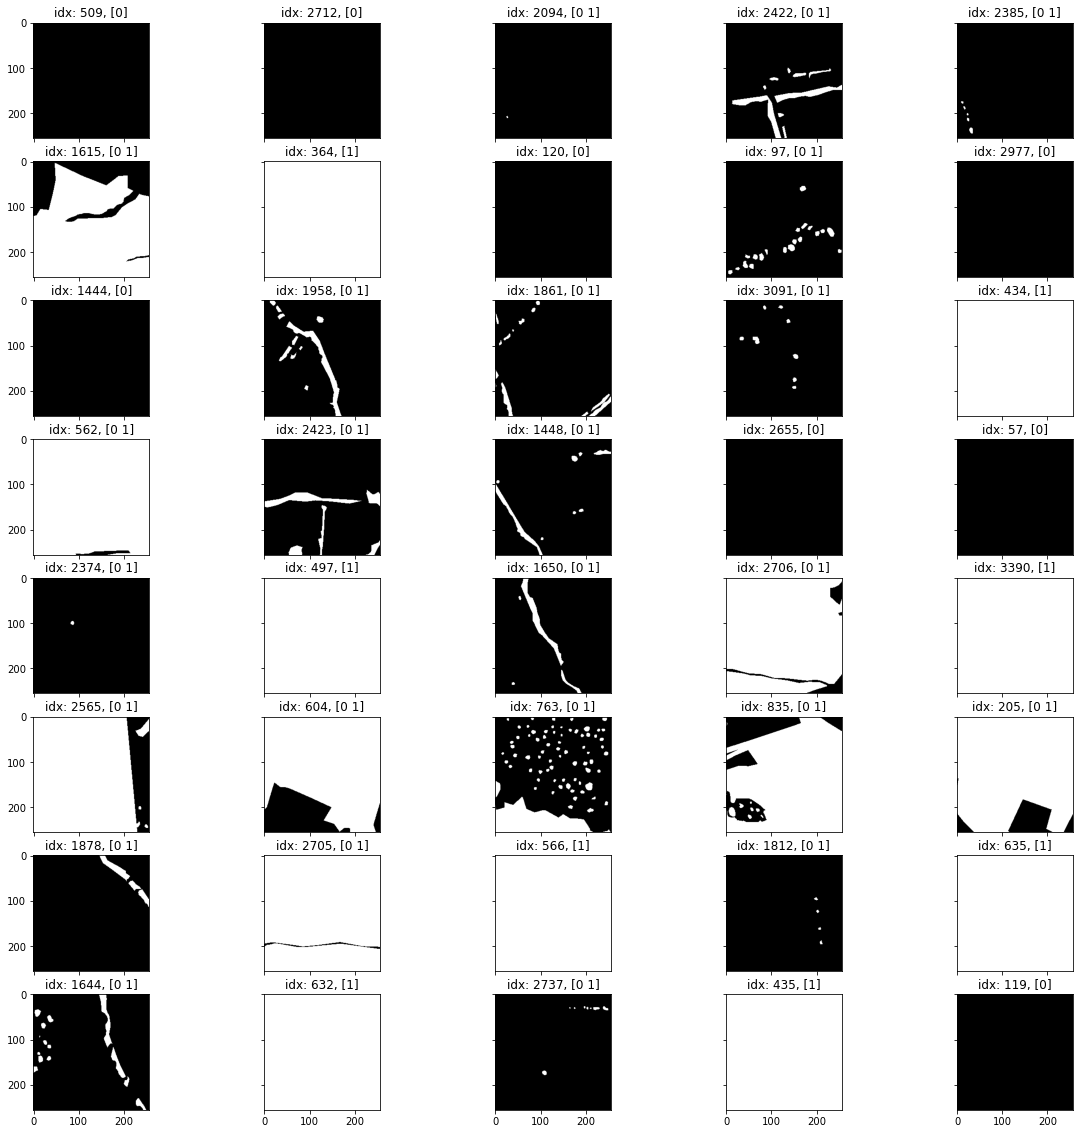

In [5]:
# Plot
n_col = 5
n_row = int(len(y_test)/n_col)

_, axs = plt.subplots(n_row, n_col, figsize=(20,20), sharex=True, sharey=True)
axs = axs.flatten()
cmap = cm.get_cmap('gray')
random.Random(4).shuffle(y_test)
random.Random(4).shuffle(X_test)

for c, (i, ax) in enumerate(zip(y_test, axs)):
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap=cmap, vmin=0)
    ax.set_title(f'idx: {utis.get_file_index(i)}, {np.unique(img)}')
plt.show()

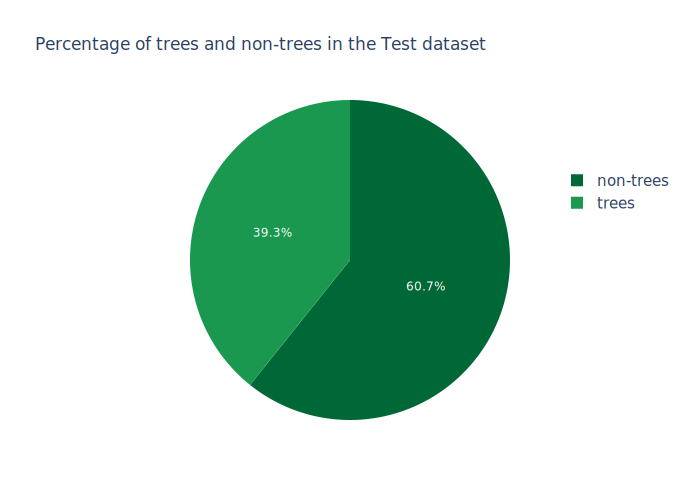

In [21]:
utis.plot_pizza(y_test, title='Test dataset')

### Check if CUDA is available

In [22]:
config.DEVICE

'cpu'

### Training and Validating

In [6]:
def train(model, dataloader, optim, lossFunc, epoch, scaler):
    # set the model in training mode
    model.train()

    # Save total train loss
    totalTrainLoss = 0
    
    # metrics
    accuracy = 0
    iou = 0
    f1score = 0
    dice = 0
    
    # loop over the training set
    loop = tqdm(dataloader, leave=False)
    for x, y in loop:
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.float().to(config.DEVICE))
        
#         # forward with autocast        
#         with autocast():
#             pred = model(x)
#             loss = lossFunc(pred, y)
            
#         optim.zero_grad()  # zero out any previously accumulated gradients    
#         scaler.scale(loss).backward() # study this 
#         scaler.step(optim)
#         scaler.update()
        
        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunc(pred, y)
        
        opt.zero_grad()  # zero out any previously accumulated gradients
        loss.backward() # obtain the gradients with respect to the loss
        opt.step() # perform one step of gradient descendent
        
        totalTrainLoss += loss  # add the loss to the total training loss so far 
        
        # metrics      
        all_metrics = metrics.metrics(pred, y)
        accuracy += all_metrics['acc']
        iou += all_metrics['iou']
        f1score += all_metrics['f1score']
        dice += all_metrics['dice_coeff']
        
        # update tqdm
        loop.set_description(f'Training Epoch [{epoch}/{config.NUM_EPOCHS}]')
        loop.set_postfix(loss=loss.item(), acc = all_metrics['acc'], iou=all_metrics['iou'], dice = all_metrics['dice_coeff'])
        
    # calculate the average training loss PER EPOCH
    avgTrainLoss = totalTrainLoss / len(dataloader)
    avgAccLoss = accuracy / len(dataloader)
    avgIOU = iou / len(dataloader)
    avgF1score = f1score / len(dataloader)
    avgDice = dice / len(dataloader)
    
    ## update training history
    training_history["avg_train_loss"].append(avgTrainLoss.cpu().detach().numpy()) # save the avg loss
    training_history["train_accuracy"].append(avgAccLoss) # save the acc 
    training_history["IoU"].append(avgIOU) # save the acc 
    
    # WANDB
    # wandb.log({
    # # "Examples": example_images,
    # "Train Loss": avgTrainLoss,
    # "Train Accuracy": avgAccLoss,
    # "IoU_train":avgIOU})
    
    return training_history

In [7]:
def validation(model, dataloader, lossFunc, epoch):
    
    # set the model in evaluation mode
    model.eval()
    # Save total train loss
    totalValLoss = 0
    
    # metrics
    accuracy_val = 0
    iou_val = 0
    f1score_val = 0
    
    example_pred = []
    example_gt = []
    # switch off autograd
    with torch.no_grad():
        # loop over the validation set
        loop = tqdm(dataloader, leave=False)
        
        for batch_idx, (x_val, y_val) in enumerate(loop):
            # send the input to the device
            (x_val, y_val) = (x_val.to(config.DEVICE), y_val.to(config.DEVICE))
            
            # make the predictions and calculate the validation loss
            pred_val = model(x_val)
            loss = lossFunc(pred_val, y_val)
            totalValLoss += loss
            
            # metrics      
            all_metrics = metrics.metrics(pred_val, y_val)
            accuracy_val += all_metrics['acc']
            iou_val += all_metrics['iou']
            f1score_val += all_metrics['f1score']

            # WandB – Log images in your test dataset automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
            # example_pred.append(wandb.Image(pred_val[0], caption=f"pred_iter_n_{batch_idx}"))
            # example_gt.append(wandb.Image(y_val[0].float(), caption=f"gt_iter_n_{batch_idx}"))
            
            # update tqdm
            loop.set_description(f'Validation Epoch [{epoch}/{config.NUM_EPOCHS}]')
            loop.set_postfix(loss_val=loss.item(), acc_val = all_metrics['acc'], iou_val=all_metrics['iou'])
                        
    # calculate the average VALIDATION loss PER EPOCH
    avgValLoss = totalValLoss / len(dataloader)
    avgAccLoss = accuracy_val / len(dataloader)
    avgIOU = iou_val / len(dataloader)
    avgF1score = f1score_val / len(dataloader)

    ## update VALIDATION history
    validation_history["avg_val_loss"].append(avgValLoss.cpu().detach().numpy()) # save the avg loss
    validation_history["val_accuracy"].append(avgAccLoss) # save the acc
    validation_history["IoU_val"].append(avgIOU) # save the acc
    
    # WANDB
    # wandb.log({
    # "Predictions": example_pred,
    # "GT": example_gt,
    # "Val Accuracy": avgAccLoss,
    # "Val Loss": avgValLoss,
    # "IoU_val": avgIOU})
    
    return validation_history

### KFold

In [16]:
# Print epoch
def train(network, 
          trainloader, 
          optimizer, 
          loss_function, 
          save_path, 
          epoch):
    
    current_loss = 0.0 # Set current loss value
    iou_train, acc = 0.0, 0.0  # metrics
    training_history = {"avg_loss": [], "accuracy": [], "iou":[]} # initialize a dictionary to store TRAINING history (keep track on training)
    loop = tqdm(trainloader, leave=False) # training tracker
    
    # Iterate over the DataLoader for training data
    for i, (x, y) in enumerate(loop, 0):

        # Get inputs
        inputs, targets = (x.to(config.DEVICE), y.to(config.DEVICE))

        # training loop
        optimizer.zero_grad() # Zero the gradients
        outputs = network(inputs)# Perform forward pass
        loss = loss_function(outputs, targets) # Compute loss
        loss.backward()# Perform backward pass
        optimizer.step() # Perform optimization
        
        # total loss
        current_loss += loss
        
        # metrics      
        all_metrics = metrics.metrics(outputs, targets)
        iou_train += all_metrics['iou']
        acc += all_metrics['acc']
        
        # update tqdm
        loop.set_description(f'Training Epoch [{epoch}/{config.NUM_EPOCHS}]')
        loop.set_postfix(loss_train=loss.item(), iou_train = iou_train, acc=acc)
    
    # averages per epoch
    avg_loss = current_loss / len(trainloader)
    avg_iou = iou_train / len(trainloader)
    avg_acc = iou_train / len(trainloader)
    
    # save
    training_history["avg_loss"].append(avg_loss.cpu().detach().numpy()) # save the avg loss
    training_history["accuracy"].append(avg_acc) # save the acc
    training_history["iou"].append(avg_iou) # save the acc
    
    # WANDB
    # wandb.log({
    # # "Examples": example_images,
    # "Train Loss": avg_loss,
    # "Train Accuracy": avg_acc,
    # "IoU_train":avg_iou})
    
    return validation_history

In [14]:
# Evaluationfor this fold
def val(network, testloader, fold, epoch):
    correct, total = 0, 0
    iou_val = 0
    
    with torch.no_grad():
        loop = tqdm(testloader, leave=False)
        
        # Iterate over the test data and generate predictions
        for i, (x, y) in enumerate(loop, 0):

            # Get inputs
            inputs, targets = (x.to(config.DEVICE), y.to(config.DEVICE))

            # Generate outputs
            outputs = network(inputs)

            # metrics      
            all_metrics = metrics.metrics(outputs, targets)
            iou_val += all_metrics['iou']
            
            # update tqdm
            loop.set_description(f'Validation Epoch [{epoch}/{config.NUM_EPOCHS}]')
            loop.set_postfix(iou_val = iou_val)
        
    avgIOU = iou_val / len(testloader)

    # Print accuracy
    print('IoU for fold %d: %d %%' % (fold, 100.0 * avgIOU))
    print('--------------------------------')
    results = 100.0 * (avgIOU)
    
    return results

In [15]:
np.arange(20,285,5)

array([ 20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,
        85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145,
       150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210,
       215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275,
       280])

In [17]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True, random_state=42)

# load the datasetsuscuic
dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
results = {}
save_path = '../best_model/coarse_sizes'

dir_to_create = os.path.join(save_path, str(n_patches))

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[],"f1score":[], "avgDice":[]}

# # initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[], "f1score_val":[]}

for fold,(train_idx, test_idx) in enumerate(kfold.split(dataset)):
    print('------------fold no---------{}----------------------'.format(fold))
    print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE}''') # try with logger

    # best iou accuracy to save
    best_accuracy = 0
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx) 
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
    # print('number of train samples', len(train_subsampler))
          
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=config.BATCH_SIZE, sampler=train_subsampler)
    
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=config.BATCH_SIZE, sampler=test_subsampler)
    
    # Model, optmizer, loss
    unet = model.unet_model.to(config.DEVICE)
    opt = optim.Adam(unet.parameters(), lr=config.LR)
    lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
    scaler = GradScaler()
    
    # reset weights
    unet.apply(train_val_test.reset_weights)

    for epoch in range(0, 1):
        trained = train(unet, train_dataloader, opt, lossFunc, save_path, epoch)
        dic_results = val(unet, testloader, fold, epoch)
        
        if not os.path.exists(dir_to_create):
            utis.create_new_dir(dir_to_create)
        
        # Save best model
        if dic_results > best_accuracy: # maybe add a minimum number of epochs as conditions
            # Saving the model
            results[fold] = dic_results
            utis.save_model(unet, dir_to_create, fold, dic_results,epoch)
            best_accuracy = dic_results

------------fold no---------0----------------------
Training the network for 1 epochs, with a batch size of 16


IoU for fold 0: 16 %
--------------------------------
------------fold no---------1----------------------
Training the network for 1 epochs, with a batch size of 16


IoU for fold 1: 24 %
--------------------------------
------------fold no---------2----------------------
Training the network for 1 epochs, with a batch size of 16


IoU for fold 2: 44 %
--------------------------------
------------fold no---------3----------------------
Training the network for 1 epochs, with a batch size of 16


IoU for fold 3: 33 %
--------------------------------
------------fold no---------4----------------------
Training the network for 1 epochs, with a batch size of 16


IoU for fold 4: 35 %
--------------------------------


In [ ]:
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} :%')

In [45]:
dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
results = {}
save_path = '../best_model/coarse_sizes'

dir_to_create = os.path.join(save_path, str(n_patches))

for fold,(train_idx, test_idx) in enumerate(kfold.split(dataset)):
    print(len(train_idx))

208
208
208
208
208


### MAIN

In [17]:
# WandB – Initialize a new run
# wandb.init(entity="vibferreira", project="master_thesis")

# classes
classes = ('no_vegetation', 'vegetation')

# Initialize model
unet = model.unet_model.to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

opt = optim.Adam(unet.parameters(), lr=config.LR)
# opt = optim.SGD(unet.parameters(), lr=config.LR, momentum=0.95, weight_decay=0.01)
scheduler = ReduceLROnPlateau(opt, mode='max', factor=0.1, patience=10, verbose=True)

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[],"f1score":[], "avgDice":[]}

# # initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[], "f1score_val":[]}

# Using log="all" log histograms of parameter values in addition to gradients
# wandb.watch(unet, log="all")

# Autocasting 
scaler = GradScaler()

# initialize best accuracy
best_accuracy = 0.0
print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE}''') # try with logger

# loop = tqdm(range(config.NUM_EPOCHS))
iter_ = 0
for e in range(config.NUM_EPOCHS):
    trained = train(unet, train_dataloader, opt, lossFunc, epoch=e, scaler=scaler)
    validated = validation(unet, val_dataloader, lossFunc, epoch=e)
    # scheduler.step(validated['IoU_val'][-1])
    
    # Save best model
    if validated['IoU_val'][-1] > best_accuracy and e > 10: # maybe add a minimum number of epochs as conditions
        utis.save_best_model(unet, BEST_MODEL, validated, e, data_portion, rate_of_coarse_labels=n_patches)
        best_accuracy = validation_history['IoU_val'][-1]

Training the network for 1 epochs, with a batch size of 16


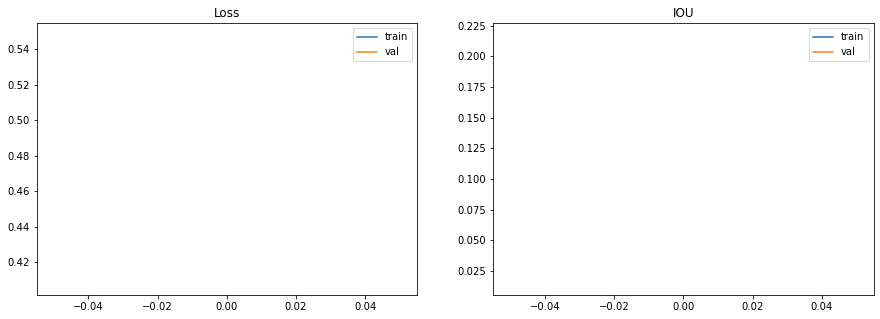

In [18]:
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(training_history['avg_train_loss'], label= 'train')
ax[0].plot(validation_history['avg_val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(training_history['IoU'], label= 'train')
ax[1].plot(validation_history['IoU_val'], label='val')
ax[1].set_title('IOU')
ax[1].legend()
plt.show()

### Predictions

In [19]:
# set the model in evaluation model
BEST_MODEL = '../best_model/coarse_sizes/'
best_iou_model = glob.glob(BEST_MODEL + '/*.pth')[0]
# best_iou_model = [i for i in best_iou_model if i.startswith(data_portion, 14)][0]
print(best_iou_model)
folder = '../saved_images'

model_ = model.unet_model.to(config.DEVICE)
model_.load_state_dict(torch.load(best_iou_model))

y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder, print_pred=False, save_patches=True)

../best_model/coarse_sizes/rate_285_coarse_labels_best_model_epoch_77_iou_0.93_acc_0.972.pth
Saving patch_0_id_509.tif
Saving patch_1_id_2712.tif
Saving patch_2_id_2094.tif
Saving patch_3_id_2422.tif
Saving patch_4_id_2385.tif
Saving patch_5_id_1615.tif
Saving patch_6_id_364.tif
Saving patch_7_id_120.tif
Saving patch_8_id_97.tif
Saving patch_9_id_2977.tif
Saving patch_10_id_1444.tif
Saving patch_11_id_1958.tif
Saving patch_12_id_1861.tif
Saving patch_13_id_3091.tif
Saving patch_14_id_434.tif
Saving patch_15_id_562.tif
Saving patch_16_id_2423.tif
Saving patch_17_id_1448.tif
Saving patch_18_id_2655.tif
Saving patch_19_id_57.tif
Saving patch_20_id_2374.tif
Saving patch_21_id_497.tif
Saving patch_22_id_1650.tif
Saving patch_23_id_2706.tif
Saving patch_24_id_3390.tif
Saving patch_25_id_2565.tif
Saving patch_26_id_604.tif
Saving patch_27_id_763.tif
Saving patch_28_id_835.tif
Saving patch_29_id_205.tif
Saving patch_30_id_1878.tif
Saving patch_31_id_2705.tif
Saving patch_32_id_566.tif
Saving p

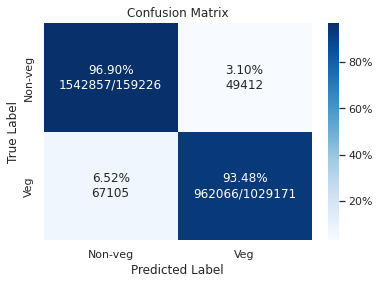

              precision    recall  f1-score   support

     Non-veg       0.96      0.97      0.96   1592269
         Veg       0.95      0.93      0.94   1029171

    accuracy                           0.96   2621440
   macro avg       0.95      0.95      0.95   2621440
weighted avg       0.96      0.96      0.96   2621440

IoU 0.8919721
F1 score 0.94290197
Dice score 0.94290197


In [20]:
labels = [0,1]
target_names = ['Non-veg', 'Veg']
metrics.cm_analysis(y_true, y_hat, labels, target_names)

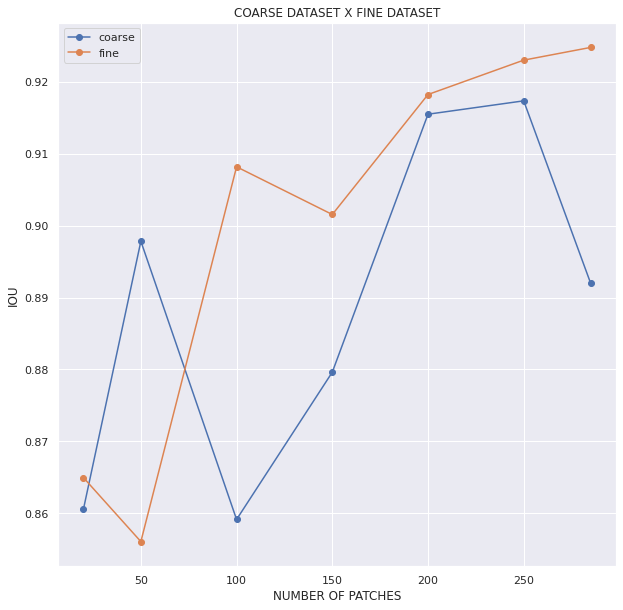

In [21]:
rates = [20, 50, 100, 150, 200, 250, 285]

# COARSE MODELS
folder = '../saved_images'
BEST_MODEL_COARSE = '../best_model/coarse_sizes'
best_iou_model_coarse = glob.glob(BEST_MODEL_COARSE + '/*.pth')
best_iou_model_coarse = sorted(best_iou_model_coarse, key= lambda x: int(re.split(r"[/_.]\s*", x)[8])) # sort files based on the number of patches

# FINE MODELS
BEST_MODEL_FINE = '../best_model/fine_sizes'
best_iou_model_fine = glob.glob(BEST_MODEL_FINE + '/*.pth')
best_iou_model_fine = sorted(best_iou_model_fine, key= lambda x: int(re.split(r"[/_.]\s*", x)[8])) # sort files based on the number of patches
  
iou_coarse = utis.iou_on_test_dataset(best_iou_model_coarse, rates, test_dataloader, X_test, folder)
iou_fine = utis.iou_on_test_dataset(best_iou_model_fine, rates, test_dataloader, X_test, folder)

plt.figure(figsize=(10,10))
plt.plot(iou_coarse.keys(),  iou_coarse.values(), label='coarse', marker='o')
plt.plot(iou_fine.keys(),  iou_fine.values(), label = 'fine', marker='o')
plt.legend()
plt.xlabel('NUMBER OF PATCHES')
plt.ylabel('IOU')
plt.title(f'COARSE DATASET X FINE DATASET')
plt.show()

In [22]:
# # WandB – Initialize a new run
# # wandb.init(entity="vibferreira", project="master_thesis")

# # set the model in evaluation model
# data_portion= 'coarse_labels'
# BEST_MODEL = '../best_model'
# best_iou_model = glob.glob(BEST_MODEL + '/*.pth')
# best_iou_model = [i for i in best_iou_model if i.startswith(data_portion, 14)][0]
# print(best_iou_model)
# folder = '../saved_images'

# # load the model 
# model_ = model.unet_model.to(config.DEVICE)
# model_.load_state_dict(torch.load(best_iou_model))

# y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder)

In [23]:
# # set the model in evaluation model
# BEST_MODEL = '../best_model'
# best_iou_model = glob.glob(BEST_MODEL + '/*.pth')
# best_iou_model.sort()
# portions = ['coarse_plus_fine_labels', 'coarse_labels', 'fine_labels']
# portions.sort()
# folder = '../saved_images'

# for i, p in zip(best_iou_model, portions):
#     # load the model 
#     model_ = model.unet_model.to(config.DEVICE)
#     model_.load_state_dict(torch.load(i))
    
#     y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder, print_pred=False)
#     y_hat, y_true, y_score = y_hat.detach().cpu().numpy(), y_true.detach().cpu().numpy(), y_score.detach().cpu().numpy()
    
#     fpr, tpr, thresholds = roc_curve(y_true, y_score)
#     roc_auc = auc(fpr, tpr)

#     lw = 2
#     plt.plot([0, 1], [0, 1], color='navy', linestyle='--', alpha=0.15)
#     plt.plot(fpr, tpr, lw=lw, label=f'{p} (area = {roc_auc: 0.4f})')

#     plt.xlabel('Specificity - False Positive Rate')
#     plt.ylabel('Sensitivity - True Positive Rate')
#     plt.title(f'ROC')
#     plt.legend(loc="lower right")